In [ ]:
 %matplotlib
GRID = 0 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from scipy.linalg import diagsvd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
import functools
import mca
import prince
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC



np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
pd.set_option('display.precision', 5)
pd.set_option('display.max_columns', 25)

AC_cols = ["annee", "distrib.id", "mois", "categ.copies", "categ.entrees", "ALLObudget", "AE", "Genre",
          "categ.devis", "rang", "ALLOduree"]

AC_cols = [ "categ.copies",  "categ.devis", "AE", "Genre"]


def one_hot_convert(df, col, drop = 0, lower = 1):
    if lower : col = col.lower()
    encoder = LabelBinarizer()
    for i in df[col]:
        if type(i) == str or not np.isnan(i):
            fillna = i
            break
    if type(i)==str:
        fillna = "nan"
    else:
        fillna = -1
    df[col] = df[col].fillna(fillna)
    oneHot = encoder.fit_transform(df[col])
    colnames = [col + '_' + str(_).lower() for _ in sorted(list(df[col].unique()))]
    tmp = pd.DataFrame(oneHot, columns=colnames)
    tmp = tmp.set_index(df.index)
    df = pd.concat([df, tmp], axis = 1)
    if col +"_"+ str(fillna) in df.columns:
        df = df.drop(col +"_"+ str(fillna), axis = 1)
    if drop : 
        df = df.drop(col, axis = 1)
    return df

def to_num(df, col, sort_flag = 0, reference = []):
    global categ_dico
    col = col.lower()
    if not len(reference):
        reference = list(df[col].unique())
    if sort_flag :
        reference.sort()
    df[col] = df[col].apply(lambda x:reference.index(x))
    categ_dico[col] = reference
    return reference


def R2(Yreal, Ysoum):
    E = Yreal-Ysoum
    y = Yreal - Yreal.mean()
    return 1 - (E*E).sum()/(y*y).sum()

def preprocess_B2():
    CINE.insert(3, "categ.devis", CINE2["categ.devis"])
    CINE.insert(1, "categ.entrees", CINE2["categ.entrees"])

def preprocess_B1(drop = True):
    if drop:
        CINE = CINE.dropna()
    to_num_B1()
    onehot_B1
    
def onehot_B1():
    global cine, CINE
    cine = one_hot_convert(CINE, "Genre", drop = 1)
    cine = one_hot_convert(cine, "produc", drop = 1)
    cine = one_hot_convert(cine, "distrib", drop = 1)
    cine = one_hot_convert(cine, "origine", drop = 1)
    cine = cine.drop("categ.copies", 1)
    cine = cine.drop("categ.entrees", 1)
    cine = cine.drop("categ.devis", 1)
    cine = cine.drop("coc", 1)
    return cine

def to_num_B1():
    global CINE
    to_num(CINE, "distrib")
    to_num(CINE, "produc", reference = categ_dico["distrib"])
    to_num(CINE, "origine")
    to_num(CINE, "coc")
    tmp = CINE["categ.copies"].unique()
    mask = [6, 0, 5, 2, 1, 4, 3, 7, 8, 9]
    tmp = tmp[mask]
    to_num(CINE, "categ.copies", reference = list(tmp))


def MCA_plot(AACP, verbose = 1, drop_tar = 1):
    if drop_tar : ACP = AACP.drop("categ.entrees", 1)
    mca = prince.MCA(
     n_components=5,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto'
    )
    MCA = mca.fit(ACP)
    MCAa = mca.fit_transform(ACP)
    if verbose:
        ax = MCA.plot_coordinates(
            X=ACP,
            ax=None,
            figsize=(20,20),
            show_row_points=1,
            row_points_size=10,
            show_row_labels=False,
            show_column_points=True,
            column_points_size=300,
            show_column_labels=True,
            legend_n_cols=2
            )
    return MCAa

def plot_mca_3D(MCAa, ACP, cols = "Blues"):
    mask = [0,1,2,6,8,3,7,9,4,5]
    c = ACP["categ.entrees"].unique()
    c.sort()
    c = c[mask]
    categ_copies_ord = ACP["categ.entrees"].apply(lambda x: list(c).index(x))
    return MCAa[0], MCAa[1], MCAa[2], categ_copies_ord

def lasso_handler(X, Y, alpha):
    lasso_reg = Lasso(alpha = alpha, normalize=1)
    lasso_reg.fit(X, Y)
    Y_pred = lasso_reg.predict(X)
#    coeffs = pd.DataFrame(data = lasso_reg.coef_, index =  X.columns)
#    print(coeffs)
    return Y_pred


def lasso_grid(X, Y_tar, alpha_min, alpha_max, steps = 1000):
    lin = np.transpose(np.linspace(alpha_min, alpha_max, steps))
    D = pd.DataFrame()
    D.insert(0, "alpha", lin)
    D.insert(0, "error", lin)
    D.error = D.error.apply(lambda x:R2(Y_tar, lasso_handler(X,Y_tar,x)))
    D.set_index("alpha", drop = True, inplace=True)
    plt.plot(D)
    plt.show

def filtr(df, col, val):
    return df[df[col] == val]

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)//100):
        print(m)
        model.fit(X_train[:m*100], y_train[:m*100])
        y_train_predict = model.predict(X_train[:m*100])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m*100]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

In [2]:
CINE = pd.read_csv("CINEMASHS2.csv", low_memory = 0, index_col = 0)
CINE2 = pd.read_csv("CINE2.csv", low_memory = 0, index_col = 0)
categ_dico = {}
CINE2.reset_index(inplace = True)
CINE2.insert(5, "categ.critlegit", np.ceil(CINE.critlegit))
CINE2.insert(5, "categ.critpopu", np.ceil(CINE.critpopu))
CINE2.insert(5, "critlegit", CINE.critlegit)
CINE2.insert(5, "critpopu", CINE.critpopu)
CINE2["categ.critlegit"].fillna(-1, inplace = True)
CINE2["categ.critpopu"].fillna(-1, inplace = True)
preprocess_B2()
CINE_EX = pd.DataFrame(CINE)
CINE.columns = [_.lower() for _ in list(CINE.columns)]

In [3]:
cine = onehot_B1()
X = cine.dropna()
X = X.reset_index()
X = X.drop("index", 1)
Y = X.entrees
X = X.drop("entrees", 1)

,count,mean,std,min,25%,50%,75%,max
ae,,,,,,,,
0,2621.0,796698.04388,1.40921e+06,35.0,81692.0,315690.0,870296.00,20437936.0
1,2546.0,195190.06913,4.58583e+05,0.0,8463.0,35619.0,165793.75,8512682.0


In [16]:
#### STATS DESC #######
CINE2.describe() # .to_latex()

,index,film.id,annee,idjpb,critpopu,critlegit,categ.critpopu,categ.critlegit,ALLOid,idafcae,visa,mois,...,JPBboxS1Fr,JPBboxS1Paris,JPBboxTotFr,JPBboxTotParis,semaine,boxS1Fr,boxS1pct,critmoylegit.num,critmoyautre.num,critmoypopu.num,categ.nbcrit,nbcritiques
count,9772.00000,9772.00000,9772.00000,5750.00000,8871.00000,9019.00000,9772.00000,9772.00000,9479.00000,5285.00000,9772.00000,9772.00000,...,5.60000e+03,3905.00000,5.74600e+03,5.30400e+03,9772.00000,5.67900e+03,5600.00000,9019.00000,9063.00000,8871.00000,9772.00000,9772.00000
mean,4886.50000,13569.13099,2008.47431,8439.05043,3.08910,2.96597,2.96490,2.96766,127418.34634,7447.35118,120459.06959,6.52262,...,1.98810e+05,63441.27170,5.31581e+05,1.41474e+05,26.55649,1.98600e+05,0.48301,2.96597,3.09531,3.08910,2.97943,0.57720
std,2821.07775,7680.82376,4.90239,5856.25182,0.84894,0.83627,1.53107,1.44442,73974.31063,4338.39400,14297.71689,3.52519,...,3.42582e+05,83622.03939,1.06727e+06,2.17165e+05,15.36683,3.46025e+05,0.18898,0.83627,0.77757,0.84894,1.41743,0.25517
min,1.00000,1.00000,2000.00000,1.00000,1.00000,0.00000,-1.00000,-1.00000,1317.00000,1.00000,36543.00000,1.00000,...,3.50000e+01,16.00000,3.50000e+01,1.40000e+01,1.00000,3.50000e+01,0.00732,0.00000,1.00000,1.00000,1.00000,0.00000
25%,2443.75000,6431.75000,2004.00000,1787.25000,2.50000,2.40000,3.00000,3.00000,53369.00000,3689.00000,109260.00000,3.00000,...,2.74788e+04,13859.00000,5.44922e+04,2.44248e+04,13.00000,2.65915e+04,0.35056,2.40000,2.60000,2.50000,2.00000,0.43750
50%,4886.50000,14393.50000,2009.00000,10762.00000,3.00000,3.00000,3.00000,3.00000,129507.00000,7490.00000,119633.50000,6.00000,...,8.13025e+04,34572.00000,1.70679e+05,6.63080e+04,26.00000,8.04330e+04,0.46269,3.00000,3.16667,3.00000,3.00000,0.62500
75%,7329.25000,20767.25000,2013.00000,13518.50000,3.75000,3.50000,4.00000,4.00000,196603.00000,11311.00000,132596.25000,10.00000,...,2.18193e+05,76729.00000,5.26332e+05,1.64183e+05,41.00000,2.16054e+05,0.59345,3.50000,3.66667,3.75000,4.00000,0.75000
max,9772.00000,25967.00000,2016.00000,16977.00000,5.00000,5.00000,5.00000,5.00000,251857.00000,14817.00000,145648.00000,12.00000,...,4.37872e+06,838650.00000,2.04893e+07,3.61078e+06,53.00000,4.37872e+06,1.00000,5.00000,5.00000,5.00000,5.00000,1.06667


In [71]:
categ_desc = CINE.copy(1).dropna()
categ_desc = categ_desc.drop(["rk_copies", "rk_entrees", "rk_devis"], 1)
entreevs = pd.DataFrame()
entreevs.insert(0, "entrees", categ_desc.entrees)
entreevs.insert(0, "log_entrees",  np.log(categ_desc.entrees+1))

In [75]:
entreevs.hist(bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002093ADEA908>,
      dtype=object)

In [83]:
entreevs.boxplot("log_entrees")

In [84]:
entreevs.boxplot("entrees")

In [ ]:
categ_desc.entrees = np.log(categ_desc.entrees+1)
categ_desc.groupby(["ae"])["entrees"].describe()

In [56]:
categ_desc[["critlegit", "critpopu","ae"]].boxplot(["critlegit", "critpopu"], by = "ae")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002092D166BA8>,
      dtype=object)

In [59]:
categ_desc[["critlegit", "critpopu","genre"]].boxplot(["critlegit", "critpopu"], by = "genre")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002092722AE48>,
      dtype=object)

In [64]:
categ_desc[["entrees", "ae", "genre"]].boxplot("entrees", by = ["genre", "ae"])

In [68]:
categ_desc[["entrees", "ae", "genre"]].boxplot("entrees", by = ["ae"])

In [70]:
numeric_features=categ_desc.columns
fig, ax = plt.subplots(figsize=(9,7))         # Sample figsize in inches
g = sns.heatmap(categ_desc[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "magma",ax=ax)
plt.title('Correlation matrix of EVENTS variables')
plt.show()

In [67]:
categ_desc.groupby(["genre"])["entrees"].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,869.0,12.24210,1.85236,5.37064,11.18937,12.49426,13.57678,16.14171
Animation,229.0,13.05828,1.76439,7.84542,12.10048,13.29619,14.30865,16.03291
Autre,161.0,11.87820,1.89183,5.63479,10.73195,12.11504,13.19278,15.47524
ComDram,752.0,11.01940,1.99497,5.53339,9.55918,11.17584,12.60818,16.78449
Comédie,1080.0,12.04037,1.96890,3.58352,10.87385,12.36416,13.44151,16.83290
Documentaire,381.0,9.42993,1.79751,0.00000,8.07900,9.24927,10.49507,14.86743
Drame,1313.0,10.53592,1.99535,4.44265,9.11757,10.50936,12.09483,15.34687
Horreur,121.0,11.90629,1.59807,6.24804,11.11561,12.21666,13.00816,14.79571
Sci-Fi,261.0,13.12009,1.95618,6.98749,12.26052,13.45998,14.52851,16.50584


In [23]:
categ_desc.groupby(["ae", "genre"])["entrees"].describe()

count         mean          std     min        25%  \
ae genre                                                               
0  Action         656.0  7.68199e+05  1.11394e+06   214.0  114619.75   
   Animation      187.0  1.52972e+06  1.69470e+06  3725.0  314877.50   
   Autre           83.0  4.97202e+05  7.85099e+05   279.0   49563.50   
   ComDram        235.0  4.70830e+05  1.44975e+06   458.0   34087.00   
   Comédie        805.0  7.66832e+05  1.45080e+06    35.0   86264.00   
   Documentaire    36.0  2.89803e+05  6.57701e+05   479.0    4182.75   
   Drame          275.0  3.06758e+05  4.71886e+05    84.0   29230.00   
   Horreur        113.0  3.36535e+05  3.75799e+05   516.0   81002.00   
   Sci-Fi         231.0  1.71479e+06  2.18831e+06  1082.0  301340.00   
1  Action         213.0  3.36347e+05  6.42172e+05   438.0   18758.00   
   Animation       42.0  1.81523e+05  1.98113e+05  2553.0   27369.50   
   Autre           78.0  4.72692e+05  7.33574e+05  2684.0   41827.50   
   ComDram        517.0  2.03029e+05  3.80264e+05   252.0   10285.00   
   Comédie        275.0  3.07015e+05  7.13945e+05   364.0   19993.00   
   Documentaire   345.0  6.36699e+04  2.51908e+05     0.0    3208.00   
   Drame         1038.0  1.52844e+05  3.62048e+05   206.0    7380.25   
   Horreur          8.0  1.10520e+05  1.18803e+05   625.0   35589.25   
   Sci-Fi          30.0  3.30685e+05  5.99961e+05  1798.0   15778.00   

                       50%         75%         max  
ae genre                                            
0  Action         334877.5   929591.25  10238917.0  
   Animation     1017214.0  2178613.00   9183459.0  
   Autre          173661.0   550414.00   5257883.0  
   ComDram        137592.0   474811.00  19472089.0  
   Comédie        320212.0   810531.00  20437936.0  
   Documentaire    36417.0   129083.00   2653884.0  
   Drame          113842.0   377479.50   4624444.0  
   Horreur        240196.0   464780.00   2664975.0  
   Sci-Fi         839306.0  2265179.00  14736570.0  
1  Action          72356.0   363776.00   4435249.0  
   Animation       67721.5   307483.50    678138.0  
   Autre          182623.0   505724.50   3173296.0  
   ComDram         50421.0   219694.00   3152798.0  
   Comédie         64565.0   321056.00   8512682.0  
   Documentaire     9917.0    33739.00   2863141.0  
   Drame           28002.5   131667.25   4438437.0  
   Horreur         78320.5   140755.50    373239.0  
   Sci-Fi          77014.5   263025.25   2383881.0

In [14]:
categ_desc.describe()

,entrees,copies,devis,ae,rd,rang,duree,cannes,regard,quinzaine,venise,berlin,critlegit,critpopu,nbcritiques
count,5.16700e+03,5167.00000,5.16700e+03,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000,5167.00000
mean,5.00310e+05,195.90420,1.80092e+07,0.49274,0.10528,4.55177,103.25450,0.03967,0.02439,0.02187,0.02264,0.01239,2.89302,3.11238,0.66206
std,1.09600e+06,202.84504,3.01816e+07,0.50000,0.30695,5.88416,31.80304,0.19521,0.15426,0.14627,0.14878,0.11061,0.84756,0.86851,0.19640
min,0.00000e+00,1.00000,8.17000e-01,0.00000,0.00000,1.00000,62.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.12500
25%,1.98660e+04,32.00000,2.00000e+06,0.00000,0.00000,1.00000,90.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.33333,2.50000,0.53333
50%,1.16607e+05,131.00000,5.59364e+06,0.00000,0.00000,3.00000,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,3.00000,0.66667
75%,4.89294e+05,299.00000,2.00236e+07,1.00000,0.00000,5.00000,111.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.50000,3.75000,0.81250
max,2.04379e+07,1093.00000,2.45100e+08,1.00000,1.00000,63.00000,2014.00000,1.00000,1.00000,1.00000,1.00000,1.00000,5.00000,5.00000,1.06667


In [13]:
categ_desc.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002090EDA9D30>,
      dtype=object)

In [8]:
numeric_features=cine.columns
fig, ax = plt.subplots(figsize=(9,7))         # Sample figsize in inches
g = sns.heatmap(cine[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "magma",ax=ax)
plt.title('Correlation matrix of EVENTS variables')
plt.show()

In [5]:
plt.show()

In [109]:
clustering.max()

2

In [ ]:
mask = [9, 8, 7, 4, 0, 1, 3, 5, 2, 6]

In [227]:
lasso_grid(X, Y, 0, 10000)

C:\Users\pierr\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [6]:
AC_cols = ["categ.entrees", "Genre", "categ.copies","categ.devis", "AE",  "categ.critpopu" ]
#""Genre","categ.critlegit"

In [18]:
plt.scatter(np.log(CINE.dropna().entrees+1), (CINE.dropna().copies+1), alpha = .1)

In [ ]:
x = CINE.entrees.copy(1)

In [ ]:
x.entrees.unique()[0]

In [51]:
x = CINE[CINE["entrees"]>1]

plt.hist(x.entrees.dropna())
#plt.hist((CINE.entrees.dropna()+1))
plt.show()

In [ ]:
x.columns = ["log_test"]

In [ ]:
x = np.ceil(np.log(x+1))

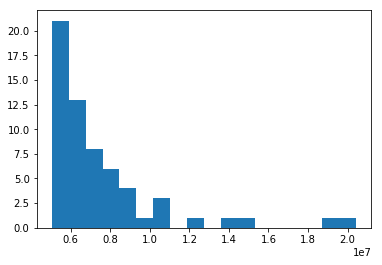

In [8]:
plt.hist(x.entrees, bins = 18)
plt.show()

In [54]:
x = CINE.dropna().groupby("categ.entrees").count()
x

,entrees,genre,copies,categ.devis,devis,distrib,produc,origine,ae,rd,coc,rang,duree,cannes,regard,quinzaine,venise,berlin,critlegit,critpopu,nbcritiques,rk_entrees,rk_copies,rk_devis,categ.copies
categ.entrees,,,,,,,,,,,,,,,,,,,,,,,,,
NotAv,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69
"[0,10)",1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125
"[10,25)",577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577
"[100,250)",724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724
"[1000,2000)",322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322
"[2000,21000]",223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223,223
"[25,50)",505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505
"[250,500)",590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590
"[50,100)",535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535,535


In [ ]:
mcaa = MCA_plot(ACP_base_nAE, verbose = 1, drop_tar = 1)
mcaa.insert(0, "categ.entrees", ACP_base_nAE["categ.entrees"])
plot_mca_3D(mcaa, ACP_base_nAE, cols = "Reds")

In [34]:
c = ACP_base["categ.entrees"].unique()
c.sort()
c[[0,1,2,6,8,3,7,9,4,5]]

array(['NotAv', '[0,10)', '[10,25)', '[25,50)', '[50,100)', '[100,250)',
       '[250,500)', '[500,1000)', '[1000,2000)', '[2000,21000]'],
      dtype=object)

In [96]:
#######MCA AND FIGURES ##########
AC_cols = ["categ.entrees", "Genre", "categ.copies","categ.devis", "AE", "categ.critpopu", "categ.critlegit" ]
#""Genre","categ.critlegit"

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ACP_base = CINE2[AC_cols]
ACP_base_AE = ACP_base[ACP_base["AE"]==1]
ACP_base_nAE = ACP_base[ACP_base["AE"]==0]
ACP_base_nAE = ACP_base_nAE.drop("AE", 1)
ACP_base_AE = ACP_base_AE.drop("AE", 1)
save = mcaa = MCA_plot(ACP_base, verbose = 1, drop_tar = 1)
mcaa.insert(0, "categ.entrees", ACP_base["categ.entrees"])
a,b,c,d = plot_mca_3D(mcaa, ACP_base)
ax.scatter(a, b, c, c = d, cmap = plt.get_cmap("Blues"))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mcaa = MCA_plot(ACP_base_nAE, verbose = 1, drop_tar = 1)
mcaa.insert(0, "categ.entrees", ACP_base_nAE["categ.entrees"])
a,b,c,d = plot_mca_3D(mcaa, ACP_base_nAE, cols = "Reds")
ax.scatter(a, b, c, c = d, cmap = plt.get_cmap("Blues"))
mcaa = MCA_plot(ACP_base_AE, verbose = 1, drop_tar = 1)
mcaa.insert(0, "categ.entrees", ACP_base_AE["categ.entrees"])
a,b,c,d = plot_mca_3D(mcaa, ACP_base_AE)
ax.scatter(a, b, c, c = d, cmap = plt.get_cmap("Reds"))

In [118]:
mcaa = MCA_plot(ACP_base, verbose = 1, drop_tar = 1)
kmeans = KMeans(n_clusters=4)
kmeans.fit(mcaa.iloc[:, 1:])
cluster = kmeans.predict(mcaa.iloc[:, 1:])

In [121]:
cluster = AgglomerativeClustering(n_clusters=4).fit_predict(mcaa.iloc[:, 1:])

In [66]:
len(mcaa[cluster == i][0])

34

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cols = ["red", "black", "blue", "cyan", "green"]
for i in range(len(cols)):
    ax.scatter(mcaa[cluster == i][0], mcaa[cluster == i][1], mcaa[cluster == i][2], c=cols[i])

In [124]:

mcaa.insert(0, "categ.entrees", ACP_base["categ.entrees"])
mcaa.insert(1, "cluster", cluster)

In [130]:
#### CLASSIF ON MCA ######
tree_cols =  ["categ.entrees", "cluster", 0 , 1 , 2 , 3 ]
mask = [9, 8, 7, 4, 0, 1, 3, 5, 2, 6]
def classif_mca(mcaa, tree_cols):
    tree_classif = DecisionTreeRegressor()
    clf=RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=10)

    CINE2tmp = mcaa[tree_cols].dropna()

    tmp = CINE2tmp["categ.entrees"].unique()[mask]
    CINE2tmp = filtr(CINE2tmp, "cluster", 3)
    CINE2tmp["categ.entrees"] = CINE2tmp["categ.entrees"].apply(lambda x: list(tmp).index(x))
    X = CINE2tmp.drop(tree_cols[0], 1)
    Y = CINE2tmp[tree_cols[0]]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)


    clf_gini = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
    clf_gini.fit(X_train, y_train)
    rez = clf_gini.predict(X_test)
    rez_train = clf_gini.predict(X_train)
    clf.fit(X_train, y_train)
    rez = clf.predict(X_test)
    rez_train = clf.predict(X_train)
    print(accuracy_score(y_train, rez_train), 
    accuracy_score(y_test, rez))
classif_mca(mcaa, tree_cols)

0.6218181818181818 0.5652173913043478


In [110]:
if "categ.entrees" not in cine.columns : cine.insert(0, "categ.entrees", CINE2["categ.entrees"])
tree_cols = ['categ.entrees', 'copies', 'devis', 'ae', 'critlegit', 'critpopu', 'genre_action', 'genre_animation', 'genre_autre',
       'genre_comdram', 'genre_comédie', 'genre_documentaire', 'genre_drame',
       'genre_horreur', 'genre_sci-fi' ]
CINE2tmp = cine[tree_cols].dropna()#

clf=RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10)
X = CINE2tmp.drop(tree_cols[0], 1)
Y = CINE2tmp[tree_cols[0]]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

clf.fit(X_train, y_train)
rez = clf.predict(X_test)
rez_train = clf.predict(X_train)
print(accuracy_score(y_train, rez_train), 
accuracy_score(y_test, rez))

0.29155238617663193 0.2578374920025592


In [ ]:
mask = [0,1,2,6,8,3,7,9,4,5]

In [137]:
######### Classif #############
tree_cols =  ["categ.entrees", "Genre", "copies",  "DEVIS", "AE", "critlegit", "critpopu"]
CINE2tmp = CINE2[tree_cols]#filtr(CINE2, "AE", 1)
#CINE2tmp["categ.entrees"]= x
#CINE2.insert(1, "cluster", cluster)
#CINE2tmp.drop("AE", 1, inplace= True)
CINE2tmp = CINE2tmp.dropna()
#tmp = CINE2tmp["categ.entrees"].unique()
#tmp.sort()
#tmp = tmp[mask]
#CINE2tmp["categ.entrees"] = CINE2tmp["categ.entrees"].apply(lambda x: list(tmp).index(x))
CINE2tmp = one_hot_convert(CINE2tmp, "Genre", drop=1, lower = 0)

X = CINE2tmp.drop(tree_cols[0], 1)
Y = CINE2tmp[tree_cols[0]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [137]:
tuned_parameters_RF = [{'n_estimators': list(range(200,1000, 200)), "max_depth" : list(range(2,10,2)), "min_samples_leaf":[5,10,20]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_RF, cv=5)
#(n_estimators=1000, max_depth=5, min_samples_leaf=10
clf.fit(X_train, y_train)

In [168]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [142]:
ada.get_params().keys()

dict_keys(['algorithm', 'base_estimator__class_weight', 'base_estimator__criterion', 'base_estimator__max_depth', 'base_estimator__max_features', 'base_estimator__max_leaf_nodes', 'base_estimator__min_impurity_decrease', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'base_estimator__min_samples_split', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__presort', 'base_estimator__random_state', 'base_estimator__splitter', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [158]:
ada_clf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__base_estimator__class_weight', 'estimator__base_estimator__criterion', 'estimator__base_estimator__max_depth', 'estimator__base_estimator__max_features', 'estimator__base_estimator__max_leaf_nodes', 'estimator__base_estimator__min_impurity_decrease', 'estimator__base_estimator__min_impurity_split', 'estimator__base_estimator__min_samples_leaf', 'estimator__base_estimator__min_samples_split', 'estimator__base_estimator__min_weight_fraction_leaf', 'estimator__base_estimator__presort', 'estimator__base_estimator__random_state', 'estimator__base_estimator__splitter', 'estimator__base_estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [178]:
tuned_parameters_RF = [{"base_estimator__criterion" : ["gini"], "base_estimator__max_depth" : [2,3,5,8], "base_estimator__min_samples_leaf":[5], 
                        "n_estimators" : [10,100,1000], "algorithm" : ["SAMME.R"], "learning_rate":[1e-4, 1e-3,1e-2]}]
tuned_parameters_RF = [{"base_estimator__criterion" : ["gini"], "base_estimator__max_depth" : [5], "base_estimator__min_samples_leaf":[5], 
                        "n_estimators" : [1000], "algorithm" : ["SAMME.R"], "learning_rate":[5e-4, 4e-4,3e-4]}]
cl =  DecisionTreeClassifier()
ada = AdaBoostClassifier(cl)
ada_clf = GridSearchCV(ada, tuned_parameters_RF, cv=5)
ada_clf.fit(X_train, y_train)


IndentationError: unexpected indent (<ipython-input-178-c4cc7b2b64b3>, line 2)

In [180]:
ada_clf.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.0004, n_estimators=1000, random_state=None)

In [181]:

ada_clf = AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.0004, n_estimators=1000, random_state=None)


ada_clf.fit(X_train, y_train)
ada_rez = ada_clf.predict(X_test)
ada_rez_train = ada_clf.predict(X_train)
clf_gini = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
clf_gini.fit(X_train, y_train)
rez_gini = clf_gini.predict(X_test)
rez_train_gini = clf_gini.predict(X_train)
clf.fit(X_train, y_train)
rez = clf.predict(X_test)
rez_train = clf.predict(X_train)
print(accuracy_score(y_train, rez_train), 
accuracy_score(y_test, rez))
print(accuracy_score(y_train, ada_rez_train), 
accuracy_score(y_test, ada_rez))

0.6065481230595541 0.445687952600395
0.5399379057296076 0.4759710335747202


In [138]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
voting_clf = VotingClassifier(
estimators=[('ada_clr', ada_clf), ('clf', clf)],
voting='hard'
)
voting_clf.fit(X_train, y_train)
voting_rez = voting_clf.predict(X_test)
voting_rez_train = voting_clf.predict(X_train)
print(accuracy_score(y_train, voting_rez_train), 
accuracy_score(y_test, voting_rez))

TypeError: get_params() missing 1 required positional argument: 'self'

In [ ]:
lasso_handler(X, Y, 1000)

In [ ]:
one_hot_convert(CINE2, "Genre", drop=1)[["categ.entrees", "copies",  "DEVIS", "AE",  "critpopu" ]]

In [ ]:
confusion_matrix(y_test, ada_rez)

In [183]:
if "categ.entrees" in cine.columns:
    cine = cine.drop("categ.entrees", 1)
if "rk_entrees" in cine.columns:
    cine = cine.drop("rk_entrees", 1)
    

In [223]:
tree_cols

Index(['entrees', 'copies', 'devis', 'ae', 'rd', 'rang', 'duree', 'cannes',
       'regard', 'quinzaine', 'venise', 'berlin', 'critlegit', 'critpopu',
       'nbcritiques', 'rk_copies', 'rk_devis', 'genre_action',
       'genre_animation', 'genre_autre', 'genre_comdram', 'genre_comédie',
       'genre_documentaire', 'genre_drame', 'genre_horreur', 'genre_sci-fi',
       'produc_1', 'produc_2', 'produc_3', 'produc_4', 'produc_5', 'produc_9',
       'produc_notav', 'produc_majorfr', 'produc_majorus', 'produc_tvfr',
       'distrib_1', 'distrib_2', 'distrib_3', 'distrib_4', 'distrib_5',
       'distrib_9', 'distrib_notav', 'distrib_majorfr', 'distrib_majorus',
       'distrib_tvfr', 'origine_europe', 'origine_f100', 'origine_majo',
       'origine_mino', 'origine_tiers', 'origine_usa'],
      dtype='object')

In [191]:
######## LOG REG ##################

tree_cols =  cine.columns
#tree_cols = list(tree_cols)
#tree_cols.append("cluster")
tree_classif = DecisionTreeRegressor()
CINE2tmp = cine[tree_cols]
CINE2tmp = CINE2tmp.dropna() # 
CINE2tmp.entrees = np.log(CINE2tmp.entrees+1)
CINE2tmp.copies = np.log(CINE2tmp.copies+1)
#CINE2tmp = filtr(CINE2tmp, "ae", 0)
#CINE2tmp.insert(1, "cluster", cluster)

#CINE2tmp.devis = np.log(CINE2tmp.devis+1)
#CINE2tmp.drop("ae", 1, inplace= True)
#tmp = CINE2tmp["categ.entrees"].unique()[mask]
#CINE2tmp["categ.entrees"] = CINE2tmp["categ.entrees"].apply(lambda x: list(tmp).index(x))
#CINE2tmp = one_hot_convert(CINE2tmp, "Genre", drop=1)
X = CINE2tmp.drop(tree_cols[0], 1)
Y = CINE2tmp[tree_cols[0]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)


In [192]:
tuned_parameters_RF = [{'n_estimators': list(range(200,1000, 200)), "max_depth" : list(range(2,10,2)), "min_samples_leaf":[5,10,20]}]
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters_RF, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [200, 400, 600, 800], 'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [193]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [194]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_leaf=20)
clf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [205]:
tuned_parameters_gbrt = [{'n_estimators': [1000], "max_depth" : [3,4],
                        "learning_rate":[1e-2,2e-2]}]

gbrt = GradientBoostingRegressor()


gbrt = GridSearchCV(gbrt, param_grid=tuned_parameters_gbrt, cv=5)
gbrt.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [1000], 'max_depth': [3, 4], 'learning_rate': [0.01, 0.02]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [206]:
gbrt.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [201]:
clf_gini = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X_train, y_train)


gbrt =GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
#GradientBoostingRegressor(max_depth=5, n_estimators=1000, learning_rate=0.005)
gbrt.fit(X_train, y_train)
gbrt_rez = gbrt.predict(X_test)
gbrt_rez_train = gbrt.predict(X_train)
clf_gini.fit(X_train, y_train)
rez = clf_gini.predict(X_test)
rez_train = clf_gini.predict(X_train)
clf.fit(X_train, y_train)
rez = clf.predict(X_test)
rez_train = clf.predict(X_train)
print(r2_score(y_train, rez_train), 
r2_score(y_test, rez))
print(r2_score(y_train, gbrt_rez_train), 
r2_score(y_test, gbrt_rez))
tot_rez = clf.predict(X)

C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9317959637738426 0.8858221039963141
0.9165229305340854 0.8919197210776865


In [31]:
CINE2tmp.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D7BEEA320>,
      dtype=object)

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X.index, Y)
ax.plot(X.index, tot_rez)

In [28]:
fig.show()

In [216]:
########  REG ##################

tree_cols =  cine.columns
#tree_cols = list(tree_cols)
#tree_cols.append("cluster")
tree_classif = DecisionTreeRegressor()
CINE2tmp = cine[tree_cols]
CINE2tmp = CINE2tmp.dropna() # 
#CINE2tmp = filtr(CINE2tmp, "ae", 0)
#CINE2tmp.insert(1, "cluster", cluster)

#CINE2tmp.devis = np.log(CINE2tmp.devis+1)
#CINE2tmp.drop("ae", 1, inplace= True)
#tmp = CINE2tmp["categ.entrees"].unique()[mask]
#CINE2tmp["categ.entrees"] = CINE2tmp["categ.entrees"].apply(lambda x: list(tmp).index(x))
#CINE2tmp = one_hot_convert(CINE2tmp, "Genre", drop=1)
X = CINE2tmp.drop(tree_cols[0], 1)
Y = CINE2tmp[tree_cols[0]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)


In [217]:
tuned_parameters_RF = [{'n_estimators': [10,100,1000], "max_depth" : [3,5,8], "min_samples_leaf":[5,10,20]}]
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters_RF, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 100, 1000], 'max_depth': [3, 5, 8], 'min_samples_leaf': [5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [218]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [220]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_leaf=20)
clf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [221]:
tuned_parameters_gbrt = [{'n_estimators': [1000], "max_depth" : [3,4],
                        "learning_rate":[1e-2,2e-2]}]

gbrt = GradientBoostingRegressor()


gbrt = GridSearchCV(gbrt, param_grid=tuned_parameters_gbrt, cv=5)
gbrt.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [1000], 'max_depth': [3, 4], 'learning_rate': [0.01, 0.02]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [222]:
gbrt.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [215]:
clf_gini = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X_train, y_train)


gbrt = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
#GradientBoostingRegressor(max_depth=5, n_estimators=1000, learning_rate=0.005)
gbrt.fit(X_train, y_train)
gbrt_rez = gbrt.predict(X_test)
gbrt_rez_train = gbrt.predict(X_train)
clf_gini.fit(X_train, y_train)
rez = clf_gini.predict(X_test)
rez_train = clf_gini.predict(X_train)
clf.fit(X_train, y_train)
rez = clf.predict(X_test)
rez_train = clf.predict(X_train)
print(r2_score(y_train, rez_train), 
r2_score(y_test, rez))
print(r2_score(y_train, gbrt_rez_train), 
r2_score(y_test, gbrt_rez))
tot_rez = clf.predict(X)

C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9218703851243346 0.8903195376030544
0.9156476641649665 0.894556296287457


In [ ]:
%%time
tree_cols =  cine.columns

if "categ.entrees" in cine.columns:
    cine = cine.drop("categ.entrees", 1)
if "rk_entrees" in cine.columns:
    cine = cine.drop("rk_entrees", 1)
    
tree_cols =  cine.columns
tree_classif = DecisionTreeRegressor()


clf=RandomForestRegressor(n_estimators=1000, max_depth=4, min_samples_leaf=10, bootstrap = True)

CINE2tmp = cine[tree_cols].dropna() # filtr(cine, "ae", 1)
CINE2tmp.entrees = np.log(CINE2tmp.entrees+1)

#CINE2tmp.drop("ae", 1, inplace= True)
CINE2tmp = CINE2tmp.astype("int")
#tmp = CINE2tmp["categ.entrees"].unique()[mask]
#CINE2tmp["categ.entrees"] = CINE2tmp["categ.entrees"].apply(lambda x: list(tmp).index(x))
#CINE2tmp = one_hot_convert(CINE2tmp, "Genre", drop=1)
X = CINE2tmp.drop(tree_cols[0], 1)
Y = CINE2tmp[tree_cols[0]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

#svm_reg = LinearSVR(epsilon=1.5)
#svm_reg.fit(X_train, y_train)

clf_gini = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=1000, learning_rate=0.001)


gbrt.fit(X_train, y_train)
gbrt_rez = gbrt.predict(X_test)
gbrt_rez_train = gbrt.predict(X_train)
clf_gini.fit(X_train, y_train)
rez = clf_gini.predict(X_test)
rez_train = clf_gini.predict(X_train)
clf.fit(X_train, y_train)
rez = clf.predict(X_test)
rez_train = clf.predict(X_train)
print(r2_score(y_train, rez_train), 
r2_score(y_test, rez))
print(r2_score(y_train, gbrt_rez_train), 
r2_score(y_test, gbrt_rez))

In [234]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [235]:
feature_importances

,importance
rk_copies,4.82656e-01
copies,4.80358e-01
critlegit,1.43543e-02
critpopu,1.28509e-02
nbcritiques,7.58822e-03
ae,8.89055e-04
duree,5.15433e-04
genre_documentaire,1.55999e-04
rk_devis,1.13713e-04
cluster,1.06156e-04


In [ ]:
plot_learning_curves(clf, X, Y)
1

In [226]:
##################### MINIMAL REGRESSION #######################
tree_cols =  ["ENTREES",  "DEVIS", "AE",  "genre", "critpopu", "critlegit" ]
tree_classif = DecisionTreeRegressor()
clf=RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_leaf=20)

CINE2tmp = CINE2[tree_cols].dropna()
#CINE2tmp.drop("AE", 1, inplace= True)
CINE2tmp.ENTREES = np.log(CINE2tmp.ENTREES+1)
#tmp = CINE2tmp["categ.entrees"].unique()[mask]
#CINE2tmp["categ.entrees"] = CINE2tmp["categ.entrees"].apply(lambda x: list(tmp).index(x))
CINE2tmp = one_hot_convert(CINE2tmp, "genre", drop=1)
X = CINE2tmp.drop(tree_cols[0], 1)
Y = CINE2tmp[tree_cols[0]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)


clf_gini = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
gbrt = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
gbrt.fit(X_train, y_train)
gbrt_rez = gbrt.predict(X_test)
gbrt_rez_train = gbrt.predict(X_train)
clf_gini.fit(X_train, y_train)
rez = clf_gini.predict(X_test)
rez_train = clf_gini.predict(X_train)
clf.fit(X_train, y_train)
rez = clf.predict(X_test)
rez_train = clf.predict(X_train)
print(r2_score(y_train, gbrt_rez_train), 
r2_score(y_test, gbrt_rez))

0.5541042171380025 0.5030676548886078


In [ ]:
pd.crosstab(y_test, rez)